# This notebook post-processed the data after training

A quick look of original exposure

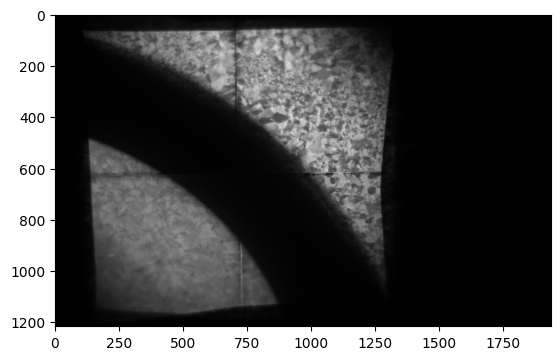

In [1]:
import numpy as np
import matplotlib.pyplot as plt

img=np.load("./img/obj1.npz")["arr_0"]
#img[150:250,400:500]=65000
#img[250:350,500:600]=65000
plt.imshow(img,cmap="gist_gray")

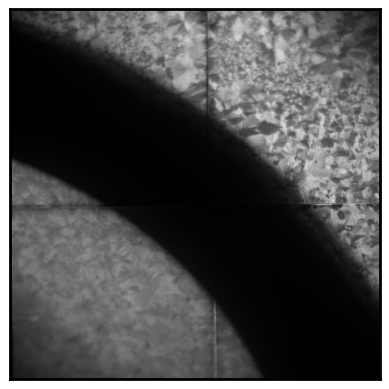

In [2]:
eff_img=img[70:1110,150:1190]
plt.imshow(eff_img,cmap="gist_gray")
plt.xticks([])
plt.yticks([])

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)

Separate pixels

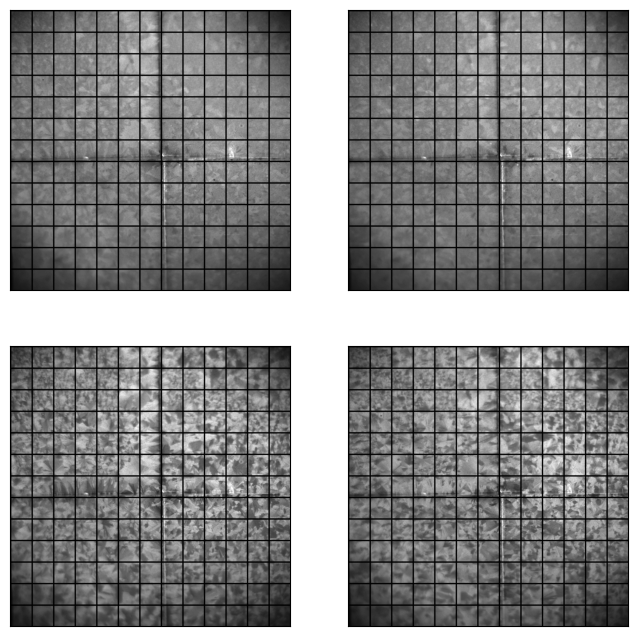

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi

def stokes_from_alphabeta(alpha,beta):
    alpha=alpha/180*pi
    beta=beta/180*pi
    result=np.zeros(3,dtype=np.float32)
    result[0]=0.5*(np.cos(4*alpha-4*beta)+np.cos(4*alpha))
    result[1]=0.5*(np.sin(4*alpha)-np.sin(4*alpha-4*beta))
    result[2]=-np.sin(4*alpha-2*beta)
    return result

fo=np.load("./dataset/alphabeta.npz")
alpha_array=fo["arr_0"]
beta_array=fo["arr_1"]
y_array=np.zeros((alpha_array.shape[0],3))
for i in range(alpha_array.shape[0]):
    y_array[i]=stokes_from_alphabeta(alpha_array[i],beta_array[i])
RCP_i=np.argmax(y_array[:,2])
LCP_i=np.argmin(y_array[:,2])
VLPL_i=np.argmax(y_array[:,0])
PLPL_i=np.argmin(y_array[:,0])
i_list=[RCP_i,LCP_i,VLPL_i,PLPL_i]

import matplotlib.pyplot as plt
f, axs = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8,8))

y_anchor=[70,150,230,310,390,470,550,630,710,790,870,950,1030]
x_anchor=[150,230,310,390,470,550,630,710,790,870,950,1030,1110]

for j in range(len(i_list)):
    idx=i_list[j]
    img=np.load("./dataset/data%d.npz"%(idx//100))["arr_0"][idx%100]

    for i in y_anchor:
        img[i:i+5,:]=0
    for i in x_anchor:
        img[:,i:i+5]=0
        
    axs[j//2,j%2].imshow(img[70:1110,150:1190],cmap="gist_gray")
    axs[j//2,j%2].set_xticks([])
    axs[j//2,j%2].set_yticks([])

Calculate Stokes parameters mapping

In [4]:
import torch
device="cpu"

In [5]:
import torch.nn as nn

class Simple_CNN(nn.Module):
    def __init__(self,p):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1,16,5,1,2),                              
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16,32,3,1,1),     
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32,64,3,1,1),     
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                
        )
        self.mlp = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(5*5*64,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,4),
        )
        
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = y.view(y.size(0), -1)       
        y = self.mlp(y)
        return y

(-1.2, 1.2)

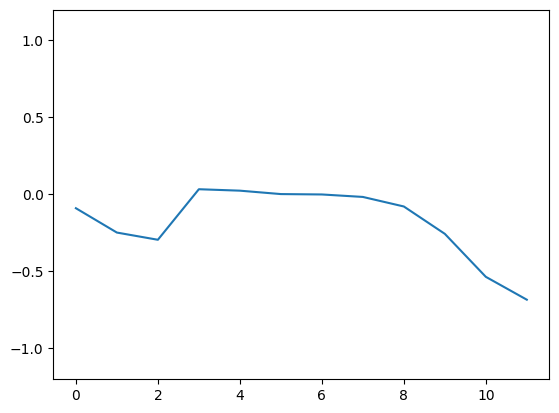

In [6]:
from scipy.ndimage import zoom
from tqdm import tqdm
from math import pi


ori_img=np.load("./img/obj1.npz")["arr_0"]
img=np.zeros((1,1,ori_img.shape[0],ori_img.shape[1]),dtype=np.float32)
img[0,0]=ori_img
result=np.zeros((12,4),dtype=np.float32)
img=img*1/65536
for i in range(12):
    ori_pixel=img[:,:,y_anchor[6]:y_anchor[6]+80,x_anchor[i]:x_anchor[i]+80]
    pixel=np.zeros((1,1,40,40),dtype=np.float32)
    pixel[0,0]=zoom(ori_pixel[0,0],(40/80,40/80))
    pixel=torch.from_numpy(pixel).to(device)
    model=torch.load("./pixels/y6_x%d_seed1212.pt"%i).to(device)
    result[i,:]=model(pixel).detach().to("cpu").numpy()

from scipy.signal import savgol_filter

plt.plot(savgol_filter(result[:,1]*result[:,0],2,1))
plt.ylim(-1.2,1.2)

In [7]:
from scipy.ndimage import gaussian_filter
ori_img=np.load("./img/obj1.npz")["arr_0"]
img=np.zeros((1,1,ori_img.shape[0],ori_img.shape[1]),dtype=np.float32)
img[0,0]=ori_img
result=np.zeros((12,4),dtype=np.float32)
img=img*1/65536

result=np.zeros((4,len(y_anchor),len(x_anchor)),dtype=np.float32)
for i in range(len(y_anchor)):
    for j in range(len(x_anchor)):
        ori_pixel=img[:,:,y_anchor[i]:y_anchor[i]+80,x_anchor[j]:x_anchor[j]+80]
        pixel=np.zeros((1,1,40,40),dtype=np.float32)
        pixel[0,0]=zoom(ori_pixel[0,0],(40/80,40/80))
        pixel=torch.from_numpy(pixel).to(device)
        model=torch.load("./pixels/y%d_x%d_seed1212.pt"%(i,j)).to(device)
        result[:,i,j]=model(pixel).detach().to("cpu").numpy()

In [54]:
"""bad_points=[[5,9],
          [6,2],
            [6,3],
          [1,2],
            [1,3],
           [9,6],
           [4,8]]"""
bad_points=[[6,2],
           [4,9],
           [6,10],
           [5,9],
           [10,12],
           [1,2],
           [6,3]]
def neighbor_i(bp):
    y_i=np.array([bp[0],bp[0],bp[0]-1,bp[0]+1])
    x_i=np.array([bp[1]-1,bp[1]+1,bp[1],bp[1]])
    if_keep=np.ones(4,dtype=bool)
    if bp[0]==0:
        if_keep[2]=False
    if bp[0]==len(y_anchor)-1:
        if_keep[3]=False
    if bp[1]==0:
        if_keep[0]=False
    if bp[1]==len(x_anchor)-1:
        if_keep[1]=False
    if_keep=np.argwhere(if_keep).reshape(-1)
    return y_i[if_keep],x_i[if_keep]


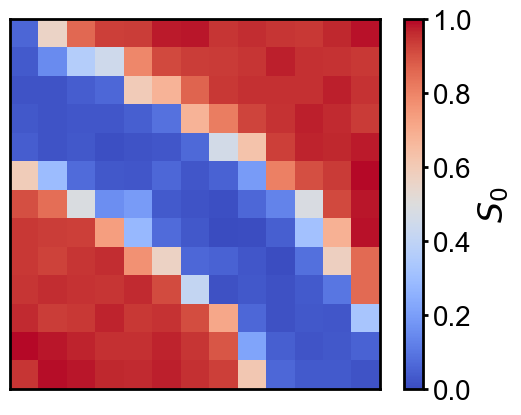

In [55]:
plt.rcParams['font.sans-serif'] = ['Arial']

cur_img=result[0]
bp=[4,8]
y_i,x_i=neighbor_i(bp)
cur_img[bp[0],bp[1]]=np.mean(cur_img[y_i,x_i])
plt.imshow(cur_img,vmin=0,vmax=1,cmap="coolwarm")
plt.xticks([])
plt.yticks([])

cbar=plt.colorbar()
#cbar.set_ticks([-0.3,-0.1,0.1,0.3])
cbar.set_label(r"$S_0$",fontsize=24)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(width=2,labelsize=20)

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)

plt.savefig("S0_img.svg",transparent=True)
plt.show()

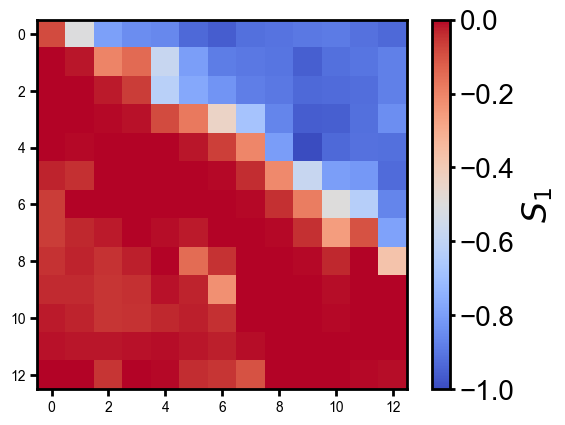

In [56]:
cur_img=result[1]*result[0]
for bp in bad_points:
    y_i,x_i=neighbor_i(bp)
    cur_img[bp[0],bp[1]]=np.mean(cur_img[y_i,x_i])
plt.imshow(gaussian_filter(cur_img,0.5),vmin=-1,vmax=0,cmap="coolwarm")
#plt.xticks([])
#plt.yticks([])

cbar=plt.colorbar()
#cbar.set_ticks([-0.3,-0.1,0.1,0.3])
cbar.set_label(r"$S_1$",fontsize=24)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(width=2,labelsize=20)

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)

plt.savefig("S1_img.svg",transparent=True)
plt.show()

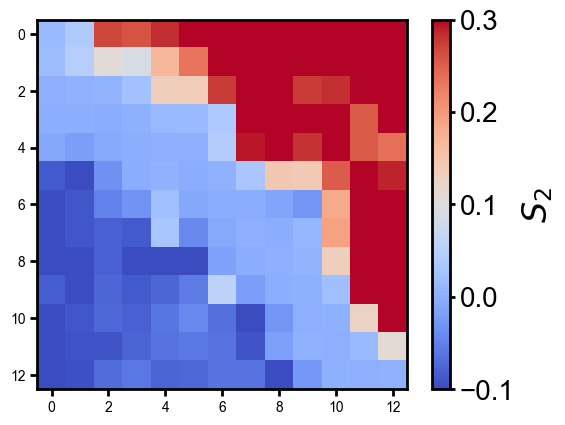

In [57]:
cur_img=result[2]*result[0]

for bp in bad_points:
    y_i,x_i=neighbor_i(bp)
    cur_img[bp[0],bp[1]]=np.mean(cur_img[y_i,x_i])
plt.imshow(gaussian_filter(cur_img,0.5),vmin=-0.1,vmax=0.3,cmap="coolwarm")
#plt.xticks([])
#plt.yticks([])

cbar=plt.colorbar()
#cbar.set_ticks([-0.3,-0.1,0.1,0.3])
cbar.set_label(r"$S_2$",fontsize=24)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(width=2,labelsize=20)

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)

plt.savefig("S2_img.svg",transparent=True)
plt.show()

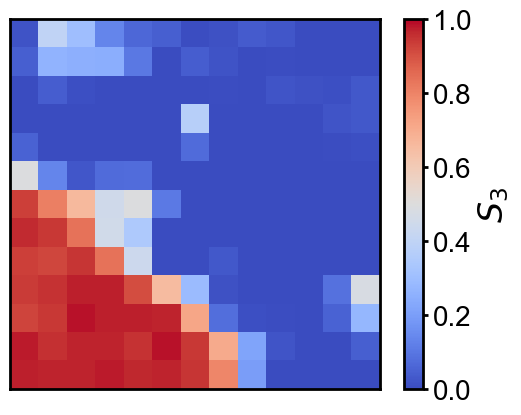

In [58]:
cur_img=result[3]*result[0]

for bp in bad_points:
    y_i,x_i=neighbor_i(bp)
    cur_img[bp[0],bp[1]]=np.mean(cur_img[y_i,x_i])
plt.imshow(gaussian_filter(cur_img,0.6),vmin=0,vmax=1,cmap="coolwarm")
plt.xticks([])
plt.yticks([])

cbar=plt.colorbar()
#cbar.set_ticks([-0.3,-0.1,0.1,0.3])
cbar.set_label(r"$S_3$",fontsize=24)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(width=2,labelsize=20)

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)

plt.savefig("S3_img.svg",transparent=True)
plt.show()

Calculate accuracy

In [71]:
import pandas as pd
MAEs=np.zeros((len(y_anchor),len(x_anchor),4))

for i in range(len(y_anchor)):
    for j in range(len(x_anchor)):
        table=pd.read_csv("./pixels/y%d_x%d_seed1212.csv"%(i,j))
        min_i=np.argmin(table["validation_loss"].values)
        MAEs[i,j]=table.iloc[min_i,7:].values
temp=MAEs.reshape(-1,4)
np.mean(temp,0),np.std(temp,0,ddof=1)

(array([0.00699297, 0.05124607, 0.05362875, 0.02893297]),
 array([0.00244009, 0.02295137, 0.02441229, 0.00554671]))

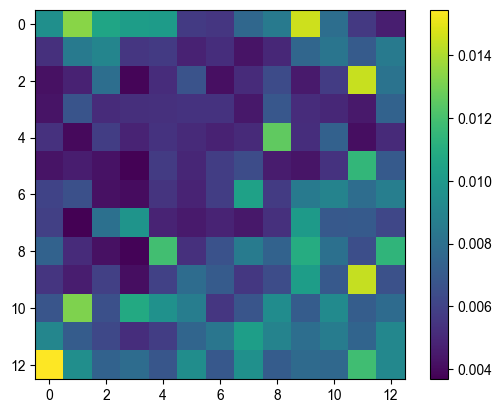

In [72]:
plt.imshow(MAEs[:,:,0])
cbar=plt.colorbar()

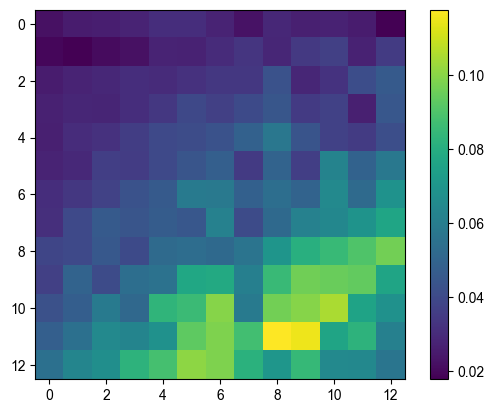

In [73]:
plt.imshow(MAEs[:,:,1])
cbar=plt.colorbar()

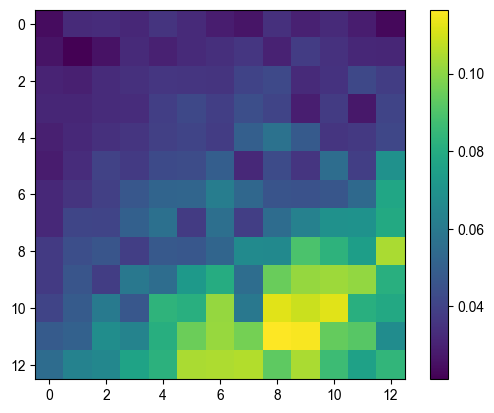

In [74]:
plt.imshow(MAEs[:,:,2])
cbar=plt.colorbar()

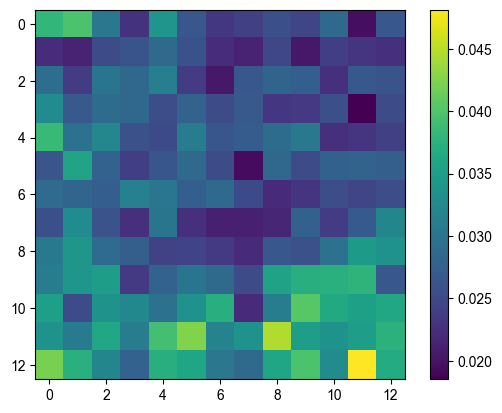

In [75]:
plt.imshow(MAEs[:,:,3])
cbar=plt.colorbar()